In [1]:
%load_ext autoreload 
%autoreload 2 

In [2]:
import torch
from torchvision.models import resnet50
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from captum.attr import IntegratedGradients
import numpy as np
from captum.attr import visualization as viz
import matplotlib.pyplot as plt

import image_manipulation as im
import evaluation as ev

In [3]:
# check if a GPU is available 
if torch.cuda.is_available():
    print('Cuda is available and used.')
    device = 'cuda'
else:
    device = 'cpu'
    print('please use a GPU for a faster performance.')

Cuda is available and used.


In [4]:
# 50 images from ImageNet data set 
import shap
import json
X, y = shap.datasets.imagenet50()

# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
print("Number of ImageNet classes:", len(class_names))

Number of ImageNet classes: 1000


In [5]:
network = resnet50(pretrained=True)
network.to(device).eval()
print('The pre-trained ResNet-50 model is loaded successfully')

The pre-trained ResNet-50 model is loaded successfully


In [6]:
# data transformation 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
data_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

softy = torch.nn.Softmax(dim=-1)

In [7]:
# integrated gradients are used in this example
ig = IntegratedGradients(network)

Calculate baseline:
The selected image is from American_egret class with 93.60928344726562%


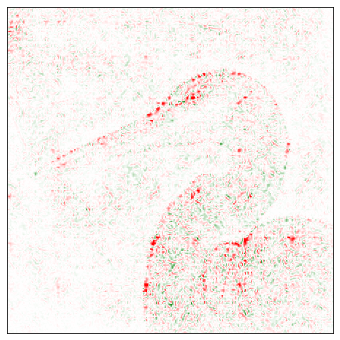

In [9]:
# Integrated Gradients
# 1 = American_egret, 2 = speedboat, 7 = mask, 15 = rapeseed, 21 = Burger, 44 = Basketball
image_index = 1

# clear the cache
torch.cuda.empty_cache()

# image preparation
image = X[image_index]
original_image = image / 255
image_to_explain = data_transform(original_image)    

# get network output and softmax it
network_output = network(image_to_explain.to(device).reshape(-1,3,224,224).float())
network_output = softy(network_output)

# get top prediction probability and class
topk_prob, topk_label = torch.topk(network_output, 1000)
target = topk_label[0][0]
class_prob = topk_prob[0][0]
print("Calculate baseline:")
print('The selected image is from {} class with {}%'.format(class_names[target], class_prob * 100))

# add dimension in front of image (needed for IG)
ig_image = data_transform(image).unsqueeze(0)
attribution_ig = ig.attribute(ig_image.to(device), target = target.item())
attribution_ig = np.transpose(attribution_ig.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

# Plot the explanation from IG
''' 
Options for method: heat_map, blended_heat_map, original_image
Options for sign: positive, negative, all, absolute_value
'''

overlayed_image = viz.visualize_image_attr(attribution_ig, original_image, method="heat_map",sign="all",show_colorbar=False, 
                        title="")


Calculate baseline:
The selected image is from class 132 with 93.60926818847656%


4 Options:   0%|          | 0/4 [00:00<?, ?it/s]

Option 1:   0%|          | 0/64 [00:00<?, ?it/s]

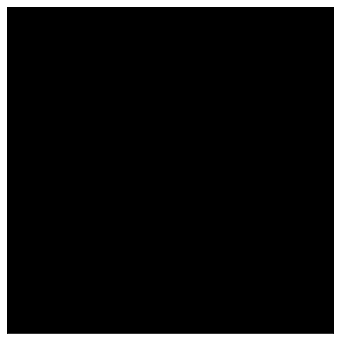

Option 2:   0%|          | 0/64 [00:00<?, ?it/s]

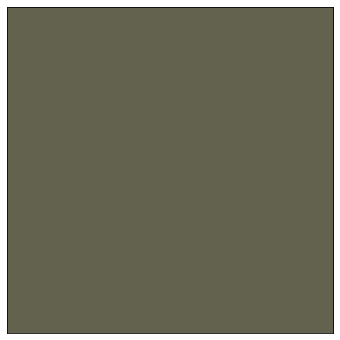

Option 3:   0%|          | 0/64 [00:00<?, ?it/s]

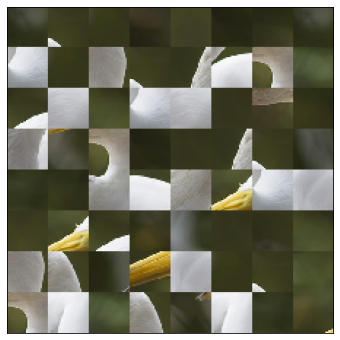

Option 4:   0%|          | 0/64 [00:00<?, ?it/s]

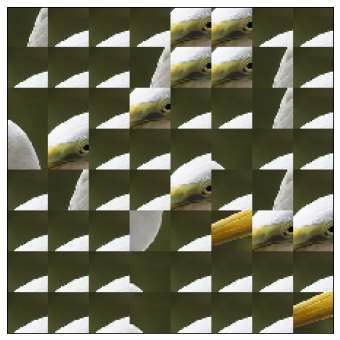

In [10]:
# with cosine similarity DAUC
# 2,4,7,8,14,16,28,32
patch_size = 8

"""
patch_option:   0 = test without removing any patch
                1 = black insertion
                2 = mean color of original image
                3 = random other patch
                4 = most cosine distant patch
"""
# option needs to be in ascending order, even if some are left out, 
# because graph generation is based on this order
option = [1,2,3,4]

# create patches from attribution and image
patches_attribution = im.make_patches(attribution_ig, patch_size)
patches_original = im.make_patches(original_image, patch_size)

prob_list = ev.patch_dauc(patches_attribution,patches_original,network,device,option,
                        visualization=False,show_final_image=True)

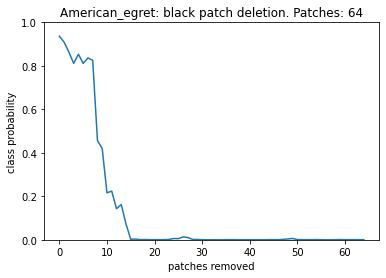

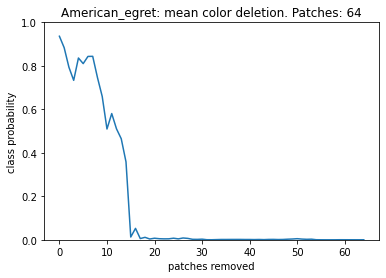

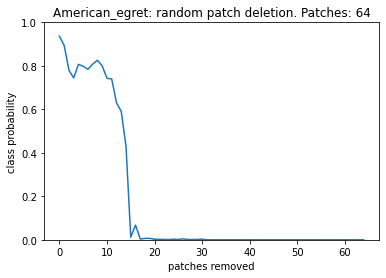

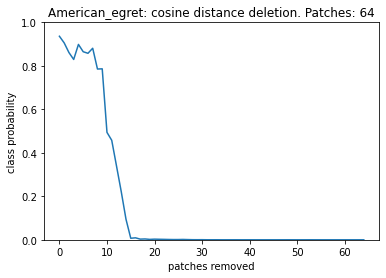

In [11]:
# make graph
rc = {"axes.spines.left" : True,
            "axes.spines.right" : True,
            "axes.spines.bottom" : True,
            "axes.spines.top" : True,
            "xtick.bottom" : True,
            "xtick.labelbottom" : True,
            "ytick.labelleft" : True,
            "ytick.left" : True}
plt.rcParams.update(rc)
"""
patch_option:   0 = test without removing any patch
                1 = black insertion
                2 = mean color of original image
                3 = random other patch
                4 = most cosine distant patch
"""
# create index list for graph visualization
index_list = []
for index in range(len(prob_list[0])):
        index_list.append(index)

plt.plot(index_list, prob_list[1])
plt.title("{}: black patch deletion. Patches: {}".format(class_names[target], patch_size**2))
plt.ylabel("class probability")
plt.xlabel("patches removed")
plt.ylim([0,1])
#plt.xlim([0,1])
plt.show()

plt.plot(index_list, prob_list[2])
plt.title("{}: mean color deletion. Patches: {}".format(class_names[target], patch_size**2))
plt.ylabel("class probability")
plt.xlabel("patches removed")
plt.ylim([0,1])
#plt.xlim([0,1])
plt.show()

plt.plot(index_list, prob_list[3])
plt.title("{}: random patch deletion. Patches: {}".format(class_names[target], patch_size**2))
plt.ylabel("class probability")
plt.xlabel("patches removed")
plt.ylim([0,1])
#plt.xlim([0,1])
plt.show()

plt.plot(index_list, prob_list[4])
plt.title("{}: cosine distance deletion. Patches: {}".format(class_names[target], patch_size**2))
plt.ylabel("class probability")
plt.xlabel("patches removed")
plt.ylim([0,1])
#plt.xlim([0,1])
plt.show()

rc = {"axes.spines.left" : True,
        "axes.spines.right" : True,
        "axes.spines.bottom" : True,
        "axes.spines.top" : True,
        "xtick.bottom" : False,
        "xtick.labelbottom" : False,
        "ytick.labelleft" : False,
        "ytick.left" : False}
plt.rcParams.update(rc)


In [12]:
# with cosine similarity IAUC
patch_size = 8

"""
patch_option:   0 = test without removing any patch
                1 = black insertion
                2 = mean color of original image
                3 = random other patch
                4 = most cosine distant patch
"""

# option needs to be in ascending order, even if some are left out, 
# because graph generation is based on this order
option = [0,1,2,3,4]

# create patches from attribution and image
patches_attribution = im.make_patches(attribution_ig, patch_size)
patches_original = im.make_patches(original_image, patch_size)

prob_list = ev.patch_iauc(patches_attribution,patches_original,network,target,device,option,
                        visualization=False)


4 Options:   0%|          | 0/5 [00:00<?, ?it/s]

Option 0 not available.


Option 1:   0%|          | 0/64 [00:00<?, ?it/s]

Option 2:   0%|          | 0/64 [00:00<?, ?it/s]

Option 3:   0%|          | 0/64 [00:00<?, ?it/s]

Option 4:   0%|          | 0/64 [00:00<?, ?it/s]

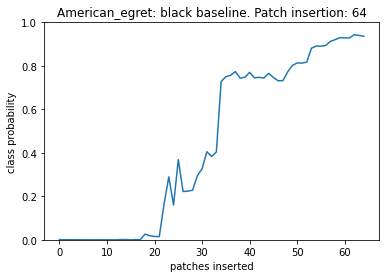

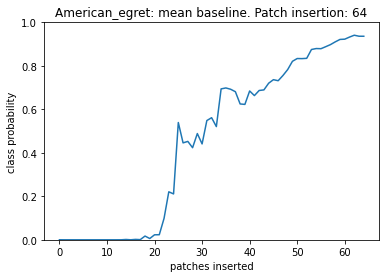

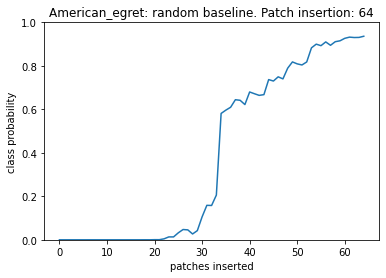

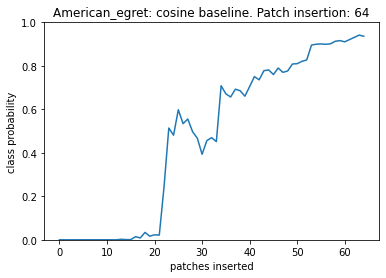

In [13]:
# make graph
rc = {"axes.spines.left" : True,
            "axes.spines.right" : True,
            "axes.spines.bottom" : True,
            "axes.spines.top" : True,
            "xtick.bottom" : True,
            "xtick.labelbottom" : True,
            "ytick.labelleft" : True,
            "ytick.left" : True}
plt.rcParams.update(rc)
"""
patch_option:   0 = test without removing any patch
                1 = black insertion
                2 = mean color of original image
                3 = random other patch
                4 = most cosine distant patch
"""
# create index list for graph visualization
index_list = []
for index in range(len(prob_list[0])):
        index_list.append(index)

plt.plot(index_list, prob_list[1], marker = "")
plt.title("{}: black baseline. Patch insertion: {}".format(class_names[target], patch_size**2))
plt.ylabel("class probability")
plt.xlabel("patches inserted")
plt.ylim([0,1])
#plt.xlim([0,1])
plt.show()

plt.plot(index_list, prob_list[2], marker = "")
plt.title("{}: mean baseline. Patch insertion: {}".format(class_names[target], patch_size**2))
plt.ylabel("class probability")
plt.xlabel("patches inserted")
plt.ylim([0,1])
#plt.xlim([0,1])
plt.show()

plt.plot(index_list, prob_list[3], marker = "")
plt.title("{}: random baseline. Patch insertion: {}".format(class_names[target], patch_size**2))
plt.ylabel("class probability")
plt.xlabel("patches inserted")
plt.ylim([0,1])
#plt.xlim([0,1])
plt.show()

plt.plot(index_list, prob_list[4], marker = "")
plt.title("{}: cosine baseline. Patch insertion: {}".format(class_names[target], patch_size**2))
plt.ylabel("class probability")
plt.xlabel("patches inserted")
plt.ylim([0,1])
#plt.xlim([0,1])
plt.show()

rc = {"axes.spines.left" : True,
        "axes.spines.right" : True,
        "axes.spines.bottom" : True,
        "axes.spines.top" : True,
        "xtick.bottom" : False,
        "xtick.labelbottom" : False,
        "ytick.labelleft" : False,
        "ytick.left" : False}
plt.rcParams.update(rc)